Download and extract dataset from google drive into /content/data directory.

You most likely need to download the dataset manually from https://doi.org/10.34808/mn4m-w821 and upload it to the colab filesystem to /content/data directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq /content/drive/MyDrive/share/data.zip -d /content/data

In [ ]:
!cd /content
!rm -r sample_data
!mkdir /content/logs /content/models

Mounted at /content/drive


In [ ]:
!pip install -q lpips==0.1.4 kornia==0.8.1 torchinfo==1.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 111.9 MB/s eta 0:00:00


In [ ]:
import os
import glob
import cv2
import numpy as np
from tqdm import tqdm
import random
from datetime import datetime
import heapq

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import lpips
import kornia as K
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available():
  print('Benchmark: ON')
  cudnn.benchmark = True

print('CPU COUNT:', os.cpu_count())

cv2.setNumThreads(0)
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)

Benchmark: ON
CPU COUNT: 12


In [ ]:
DIM = 512
TRAIN_DIM = 256
BATCH_SIZE = 4
VAL_BATCH_SIZE = 1
EPOCHS = 150
TRAIN_DIR = "/content/data/train"
VAL_DIR = "/content/data/val"
# LOG_DIR = "/content/logs"
# MODEL_PATH = "/content/models"
LOG_DIR = "/content/drive/My Drive/logs1"
MODEL_PATH = "/content/drive/My Drive/models1"

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

In [ ]:
# AUGMENTATION
color_jitter = T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15)
rand_crop = T.RandomResizedCrop(TRAIN_DIM, scale=(0.7,1.0), ratio=(1.0, 1.0))

def random_flip(t):
    if random.random() > 0.5:
        t = torch.flip(t, dims=[2])  # horizontal
    if random.random() > 0.5:
        t = torch.flip(t, dims=[1])  # vertical
    return t

def random_rot90(t):
    k = random.randint(0, 3)
    return torch.rot90(t, k, dims=[1, 2])


# DATASET
class AerialColorizationDataset(Dataset):
    def __init__(self, folder, augment = True):
        self.paths = sorted(glob.glob(os.path.join(folder, '*.png')))
        self.augment = augment

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        # img = cv2.resize(img, (DIM, DIM)) # imgs dim = 512
        if not self.augment:
          img = cv2.resize(img, (TRAIN_DIM, TRAIN_DIM))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = torch.from_numpy(img).permute(2,0,1).float().div_(255.0)

        if self.augment:
          x = color_jitter(x)
          x = random_flip(x)
          x = random_rot90(x)
          x = rand_crop(x) # DIM (512, 512) -> TRAIN_DIM

        return x # RGB [0, 1] CPU tensor


class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.concat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channel, reduction=8, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channel, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

# Hyper U-Net(+CBAM) model
class UNetCBAM(nn.Module):
    def __init__(self, use_cbam=True):
        super().__init__()

        self.enc1 = ConvBlock(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.cbam1 = CBAM(64)

        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.cbam2 = CBAM(128)

        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.cbam3 = CBAM(256)

        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.cbam4 = CBAM(512)

        if not use_cbam:
          self.cbam1 = nn.Identity()
          self.cbam2 = nn.Identity()
          self.cbam3 = nn.Identity()
          self.cbam4 = nn.Identity()

        self.bottleneck = ConvBlock(512, 512)

        self.up4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(512 + 512, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(128 + 128, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(64 + 64, 64)

        self.hyper_up2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)  # from encoder 2
        self.hyper_up_dec2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)  # from decoder 2

        self.final_conv = nn.Sequential(
            nn.Conv2d(64 + 128 + 128, 128, kernel_size=3, padding=1),  # d1 + up(conv2) + up(d2)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x1 = self.cbam1(x1)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        x2 = self.cbam2(x2)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        x3 = self.cbam3(x3)
        p3 = self.pool3(x3)

        x4 = self.enc4(p3)
        x4 = self.cbam4(x4)
        p4 = self.pool4(x4)

        bottleneck = self.bottleneck(p4)

        d4 = self.up4(bottleneck)
        d4 = self.dec4(torch.cat([d4, x4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, x3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, x2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, x1], dim=1))

        h2 = self.hyper_up2(x2)
        h_dec2 = self.hyper_up_dec2(d2)

        out = self.final_conv(torch.cat([d1, h2, h_dec2], dim=1))
        return out


class TopKCheckpoints:
    def __init__(self, k=3, mode="min", use_cbam=True, skip_first=15):
        self.k = k
        self.mode = mode
        self.tag = "cbam" if use_cbam else "plain"
        self.skip_first = skip_first  # ignore first N epochs
        self._heap = []   # stores (neg_val, epoch, path)

    def update(self, score, epoch, model, path_template):
        ep = epoch + 1
        if ep <= self.skip_first:
            return
        val = score if self.mode == "min" else -score
        out_path = path_template.format(epoch=ep, score=score, tag=self.tag)

        if len(self._heap) < self.k:
            torch.save(model.state_dict(), out_path)
            heapq.heappush(self._heap, (-val, ep, out_path))
            print(f"[TopK:{self.tag}] Saved epoch {ep}, score={score:.4f}")
        else:
            worst_val, worst_ep, worst_path = self._heap[0]
            if val < -worst_val:
                try:
                    os.remove(worst_path)
                except OSError:
                    pass
                heapq.heappop(self._heap)
                torch.save(model.state_dict(), out_path)
                heapq.heappush(self._heap, (-val, ep, out_path))
                print(f"[TopK:{self.tag}] Saved epoch {ep}, score={score:.4f} (replaced epoch {worst_ep})")

def prepare_rgb_for_lpips(L, ab):
    # L, ab: FP32 tensors (B,1,H,W) and (B,2,H,W)
    L_scaled = L * 100.0                        # [0, 1] -> [0, 100]
    ab_scaled = (ab * 128.0).clamp_(-128, 127)  # [-1, 1] -> [-128, 127]
    lab = torch.cat([L_scaled, ab_scaled], dim=1)
    rgb = K.color.lab_to_rgb(lab)
    return rgb.mul_(2.0).add_(-1.0)             # [0, 1] - [-1, 1] for LPIPS

def prepare_true_rgb_for_lpips(rgb):
    rgb_scaled = rgb.mul(2.0).add_(-1.0)      # [0, 1] - [-1, 1] for LPIPS
    return rgb_scaled

def _worker_init_fn(worker_id):
    # different seed per worker for random_flip/rot
    seed = torch.initial_seed() % 2**31
    random.seed(seed); np.random.seed(seed)

In [ ]:
# TRAINING LOOP
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    LOSS_MAE = 'MAE'
    LOSS_LPIPS = 'LPIPS'
    USE_TRAIN_LOSS = LOSS_LPIPS

    LPIPS_ALEX = 'alex'
    LPIPS_VGG = 'vgg'
    LPIPS_NET = LPIPS_VGG

    USE_CBAM = True
    model = UNetCBAM(use_cbam=USE_CBAM).to(device)
    # NHWC channels_last
    model = model.to(memory_format=torch.channels_last)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        threshold=2e-4,
        threshold_mode='abs',
        min_lr=1e-7,
    )
    criterion = nn.L1Loss().to(device)
    lpips_loss = lpips.LPIPS(net=LPIPS_NET).to(device).eval()
    for p in lpips_loss.parameters():
        p.requires_grad_(False)   # freeze LPIPS weights
    writer = SummaryWriter(log_dir=LOG_DIR)

    # AMP gradient scaler
    scaler = torch.amp.GradScaler('cuda',enabled=True)

    train_ds = AerialColorizationDataset(TRAIN_DIR, augment=True)
    val_ds   = AerialColorizationDataset(VAL_DIR, augment=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, prefetch_factor=4, pin_memory=True, persistent_workers=True, worker_init_fn=_worker_init_fn)
    val_loader = DataLoader(val_ds, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=6, prefetch_factor=2, pin_memory=True, persistent_workers=True, worker_init_fn=_worker_init_fn)

    best_val_mae_loss = float("inf")
    best_val_lpips_loss = float("inf")

    topk_mae = TopKCheckpoints(k=3, mode="min", use_cbam=USE_CBAM, skip_first=15)
    topk_lpips = TopKCheckpoints(k=3, mode="min", use_cbam=USE_CBAM, skip_first=15)

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0
        total_mae = 0.0
        # total_lpips = 0.0

        for rgb in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            rgb = rgb.to(device, non_blocking=True).to(memory_format=torch.channels_last)

            # RGB->LAB in FP32
            lab = K.color.rgb_to_lab(rgb)          # FP32
            L  = lab[:, :1].div_(100.0)            # [0,1]
            ab = lab[:, 1:].div_(128.0)            # [-1,1]

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=True):
                ab_pred = model(L.to(memory_format=torch.channels_last))
                if USE_TRAIN_LOSS == LOSS_MAE:
                    loss_mae = criterion(ab_pred, ab)
                    loss = loss_mae
                else:
                    rgb_pred = prepare_rgb_for_lpips(L, ab_pred)
                    rgb_true = prepare_true_rgb_for_lpips(rgb)
                    loss_lpips = lpips_loss(rgb_pred, rgb_true).mean()
                    loss = loss_lpips

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            if USE_TRAIN_LOSS == LOSS_MAE:
                total_mae += loss_mae.item()
            # total_lpips += loss_lpips.item()

        avg_train_loss = total_loss / len(train_loader)
        if USE_TRAIN_LOSS == LOSS_MAE:
            avg_train_mae = total_mae / len(train_loader)
        # avg_train_lpips = total_lpips / len(train_loader)

        # Validation phase
        model.eval()
        val_mae = 0.0
        val_lpips = 0.0
        psnr_total, ssim_total = 0.0, 0.0
        with torch.inference_mode():
            for rgb in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                rgb = rgb.to(device, non_blocking=True).to(memory_format=torch.channels_last)

                lab = K.color.rgb_to_lab(rgb)      # FP32
                L  = lab[:, :1].div_(100.0)
                ab = lab[:, 1:].div_(128.0)

                with torch.amp.autocast('cuda', enabled=True):
                    ab_pred = model(L.to(memory_format=torch.channels_last))

                loss_mae = criterion(ab_pred, ab)

                rgb_pred = prepare_rgb_for_lpips(L, ab_pred.float())   # ensure FP32 in helper
                rgb_true = prepare_true_rgb_for_lpips(rgb)
                loss_lpips = lpips_loss(rgb_pred, rgb_true).mean()

                val_mae += loss_mae.item()
                val_lpips += loss_lpips.item()

                psnr_total += K.metrics.psnr(rgb_pred, rgb_true, 1.0).mean().item()
                ssim_total += K.metrics.ssim(rgb_pred, rgb_true, 5, max_val=1.0).mean().item()

        avg_val_mae = val_mae / len(val_loader)
        avg_val_lpips = val_lpips / len(val_loader)
        avg_psnr = psnr_total / len(val_loader)
        avg_ssim = ssim_total / len(val_loader)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}: Train Loss (MAE): {avg_train_loss:.4f} | Val loss (MAE): {avg_val_mae:.4f} | LPIPS: {avg_val_lpips:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

        writer.add_scalar("train/loss", avg_train_loss, epoch) # MAE
        # writer.add_scalar("train/mae", avg_train_mae, epoch)
        # writer.add_scalar("train/lpips", avg_train_lpips, epoch)
        # writer.add_scalar("val/loss", avg_val_loss, epoch)
        writer.add_scalar("val/loss", avg_val_mae, epoch) # MAE
        writer.add_scalar("val/lpips", avg_val_lpips, epoch)
        writer.add_scalar("val/psnr", avg_psnr, epoch)
        writer.add_scalar("val/ssim", avg_ssim, epoch)
        writer.add_scalar("lr", current_lr, epoch)
        writer.flush()

        scheduler.step(avg_val_mae)

        tpl_prefix = "AH" if USE_CBAM else "H"
        mae_path_template = os.path.join(MODEL_PATH, f"{tpl_prefix}_U_NET_{timestamp}_MAE_ep{{epoch}}_{avg_val_mae:.4f}.pth")
        lpips_path_template = os.path.join(MODEL_PATH, f"{tpl_prefix}_U_NET_{timestamp}_LPIPS_ep{{epoch}}_{avg_val_lpips:.4f}.pth")

        topk_mae.update(avg_val_mae, epoch, model, mae_path_template)
        topk_lpips.update(avg_val_lpips, epoch, model, lpips_path_template)

        # Checkpoints
        # if avg_val_mae < best_val_mae_loss:
        #   best_val_mae_loss = avg_val_mae
        #   mae_path = os.path.join(MODEL_PATH, f'AH_U_NET_{timestamp}_MAE.pth')
        #   torch.save(model.state_dict(), mae_path)
        #   print(f"[Checkpoint] Saved new best model by MAE at epoch {epoch+1}, MAE={best_val_mae_loss:.4f}")

        # if avg_val_lpips < best_val_lpips_loss:
        #   best_val_lpips_loss = avg_val_lpips
        #   lpips_path = os.path.join(MODEL_PATH, f'AH_U_NET_{timestamp}_LPIPS.pth')
        #   torch.save(model.state_dict(), lpips_path)
        #   print(f"[Checkpoint] Saved new best model by LPIPS at epoch {epoch+1}, LPIPS={best_val_lpips_loss:.4f}")

    writer.close()


if __name__ == "__main__":
    train()


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 226MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


Epoch 1 [Val]: 100%|██████████| 1256/1256 [00:45<00:00, 27.78it/s]


Epoch 1: Train Loss (MAE): 0.1592 | Val loss (MAE): 0.0392 | LPIPS: 0.1373 | PSNR: 23.37 | SSIM: 0.8443


Epoch 2 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 2: Train Loss (MAE): 0.1377 | Val loss (MAE): 0.0411 | LPIPS: 0.1324 | PSNR: 23.05 | SSIM: 0.8404


Epoch 3 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 3: Train Loss (MAE): 0.1308 | Val loss (MAE): 0.0375 | LPIPS: 0.1212 | PSNR: 23.82 | SSIM: 0.8554


Epoch 4 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 4: Train Loss (MAE): 0.1250 | Val loss (MAE): 0.0359 | LPIPS: 0.1181 | PSNR: 24.23 | SSIM: 0.8612


Epoch 5 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 5: Train Loss (MAE): 0.1225 | Val loss (MAE): 0.0357 | LPIPS: 0.1191 | PSNR: 24.27 | SSIM: 0.8605


Epoch 6 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 6: Train Loss (MAE): 0.1203 | Val loss (MAE): 0.0349 | LPIPS: 0.1159 | PSNR: 24.60 | SSIM: 0.8664


Epoch 7 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 7: Train Loss (MAE): 0.1190 | Val loss (MAE): 0.0361 | LPIPS: 0.1175 | PSNR: 24.22 | SSIM: 0.8589


Epoch 8 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.96it/s]


Epoch 8: Train Loss (MAE): 0.1179 | Val loss (MAE): 0.0342 | LPIPS: 0.1128 | PSNR: 24.78 | SSIM: 0.8683


Epoch 9 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 9: Train Loss (MAE): 0.1165 | Val loss (MAE): 0.0339 | LPIPS: 0.1099 | PSNR: 24.75 | SSIM: 0.8688


Epoch 10 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 10: Train Loss (MAE): 0.1151 | Val loss (MAE): 0.0334 | LPIPS: 0.1094 | PSNR: 24.90 | SSIM: 0.8710


Epoch 11 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.01it/s]


Epoch 11: Train Loss (MAE): 0.1140 | Val loss (MAE): 0.0339 | LPIPS: 0.1094 | PSNR: 24.71 | SSIM: 0.8681


Epoch 12 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 12: Train Loss (MAE): 0.1136 | Val loss (MAE): 0.0330 | LPIPS: 0.1077 | PSNR: 24.95 | SSIM: 0.8721


Epoch 13 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 13: Train Loss (MAE): 0.1128 | Val loss (MAE): 0.0335 | LPIPS: 0.1085 | PSNR: 24.87 | SSIM: 0.8701


Epoch 14 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 14: Train Loss (MAE): 0.1123 | Val loss (MAE): 0.0333 | LPIPS: 0.1077 | PSNR: 24.82 | SSIM: 0.8701


Epoch 15 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 15: Train Loss (MAE): 0.1112 | Val loss (MAE): 0.0338 | LPIPS: 0.1106 | PSNR: 24.92 | SSIM: 0.8686


Epoch 16 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 16: Train Loss (MAE): 0.1107 | Val loss (MAE): 0.0337 | LPIPS: 0.1102 | PSNR: 24.73 | SSIM: 0.8676
[TopK:cbam] Saved epoch 16, score=0.0337
[TopK:cbam] Saved epoch 16, score=0.1102


Epoch 17 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 17: Train Loss (MAE): 0.1085 | Val loss (MAE): 0.0326 | LPIPS: 0.1045 | PSNR: 25.01 | SSIM: 0.8721
[TopK:cbam] Saved epoch 17, score=0.0326
[TopK:cbam] Saved epoch 17, score=0.1045


Epoch 18 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 18: Train Loss (MAE): 0.1084 | Val loss (MAE): 0.0321 | LPIPS: 0.1036 | PSNR: 25.16 | SSIM: 0.8749
[TopK:cbam] Saved epoch 18, score=0.0321
[TopK:cbam] Saved epoch 18, score=0.1036


Epoch 19 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 19: Train Loss (MAE): 0.1076 | Val loss (MAE): 0.0323 | LPIPS: 0.1038 | PSNR: 25.12 | SSIM: 0.8747
[TopK:cbam] Saved epoch 19, score=0.0323 (replaced epoch 16)
[TopK:cbam] Saved epoch 19, score=0.1038 (replaced epoch 16)


Epoch 20 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 20: Train Loss (MAE): 0.1073 | Val loss (MAE): 0.0320 | LPIPS: 0.1030 | PSNR: 25.17 | SSIM: 0.8754
[TopK:cbam] Saved epoch 20, score=0.0320 (replaced epoch 17)
[TopK:cbam] Saved epoch 20, score=0.1030 (replaced epoch 17)


Epoch 21 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 21: Train Loss (MAE): 0.1067 | Val loss (MAE): 0.0327 | LPIPS: 0.1041 | PSNR: 25.07 | SSIM: 0.8729


Epoch 22 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 22: Train Loss (MAE): 0.1060 | Val loss (MAE): 0.0318 | LPIPS: 0.1027 | PSNR: 25.23 | SSIM: 0.8756
[TopK:cbam] Saved epoch 22, score=0.0318 (replaced epoch 19)
[TopK:cbam] Saved epoch 22, score=0.1027 (replaced epoch 19)


Epoch 23 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 23: Train Loss (MAE): 0.1057 | Val loss (MAE): 0.0324 | LPIPS: 0.1051 | PSNR: 25.09 | SSIM: 0.8724


Epoch 24 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.42it/s]


Epoch 24: Train Loss (MAE): 0.1052 | Val loss (MAE): 0.0323 | LPIPS: 0.1037 | PSNR: 25.15 | SSIM: 0.8741


Epoch 25 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.96it/s]


Epoch 25: Train Loss (MAE): 0.1052 | Val loss (MAE): 0.0321 | LPIPS: 0.1031 | PSNR: 25.18 | SSIM: 0.8746
[TopK:cbam] Saved epoch 25, score=0.0321 (replaced epoch 18)
[TopK:cbam] Saved epoch 25, score=0.1031 (replaced epoch 18)


Epoch 26 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 26: Train Loss (MAE): 0.1049 | Val loss (MAE): 0.0317 | LPIPS: 0.1016 | PSNR: 25.35 | SSIM: 0.8776
[TopK:cbam] Saved epoch 26, score=0.0317 (replaced epoch 25)
[TopK:cbam] Saved epoch 26, score=0.1016 (replaced epoch 25)


Epoch 27 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 27: Train Loss (MAE): 0.1034 | Val loss (MAE): 0.0325 | LPIPS: 0.1026 | PSNR: 25.05 | SSIM: 0.8722
[TopK:cbam] Saved epoch 27, score=0.1026 (replaced epoch 20)


Epoch 28 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 28: Train Loss (MAE): 0.1026 | Val loss (MAE): 0.0325 | LPIPS: 0.1015 | PSNR: 25.08 | SSIM: 0.8736
[TopK:cbam] Saved epoch 28, score=0.1015 (replaced epoch 22)


Epoch 29 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 29: Train Loss (MAE): 0.1023 | Val loss (MAE): 0.0318 | LPIPS: 0.1009 | PSNR: 25.29 | SSIM: 0.8768
[TopK:cbam] Saved epoch 29, score=0.0318 (replaced epoch 20)
[TopK:cbam] Saved epoch 29, score=0.1009 (replaced epoch 27)


Epoch 30 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 30: Train Loss (MAE): 0.1024 | Val loss (MAE): 0.0322 | LPIPS: 0.1015 | PSNR: 25.16 | SSIM: 0.8751
[TopK:cbam] Saved epoch 30, score=0.1015 (replaced epoch 26)


Epoch 31 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 31: Train Loss (MAE): 0.1016 | Val loss (MAE): 0.0322 | LPIPS: 0.1014 | PSNR: 25.14 | SSIM: 0.8746
[TopK:cbam] Saved epoch 31, score=0.1014 (replaced epoch 30)


Epoch 32 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 32: Train Loss (MAE): 0.1011 | Val loss (MAE): 0.0327 | LPIPS: 0.1021 | PSNR: 25.03 | SSIM: 0.8730


Epoch 33 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 33: Train Loss (MAE): 0.1015 | Val loss (MAE): 0.0316 | LPIPS: 0.1002 | PSNR: 25.26 | SSIM: 0.8763
[TopK:cbam] Saved epoch 33, score=0.0316 (replaced epoch 22)
[TopK:cbam] Saved epoch 33, score=0.1002 (replaced epoch 28)


Epoch 34 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.97it/s]


Epoch 34: Train Loss (MAE): 0.1009 | Val loss (MAE): 0.0322 | LPIPS: 0.1019 | PSNR: 25.13 | SSIM: 0.8741


Epoch 35 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 35: Train Loss (MAE): 0.1007 | Val loss (MAE): 0.0321 | LPIPS: 0.1012 | PSNR: 25.17 | SSIM: 0.8749
[TopK:cbam] Saved epoch 35, score=0.1012 (replaced epoch 31)


Epoch 36 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 36: Train Loss (MAE): 0.1005 | Val loss (MAE): 0.0318 | LPIPS: 0.1006 | PSNR: 25.25 | SSIM: 0.8763
[TopK:cbam] Saved epoch 36, score=0.0318 (replaced epoch 29)
[TopK:cbam] Saved epoch 36, score=0.1006 (replaced epoch 35)


Epoch 37 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 37: Train Loss (MAE): 0.1004 | Val loss (MAE): 0.0316 | LPIPS: 0.1000 | PSNR: 25.30 | SSIM: 0.8774
[TopK:cbam] Saved epoch 37, score=0.0316 (replaced epoch 36)
[TopK:cbam] Saved epoch 37, score=0.1000 (replaced epoch 29)


Epoch 38 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 38: Train Loss (MAE): 0.1001 | Val loss (MAE): 0.0326 | LPIPS: 0.1018 | PSNR: 25.10 | SSIM: 0.8737


Epoch 39 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 39: Train Loss (MAE): 0.1005 | Val loss (MAE): 0.0318 | LPIPS: 0.1006 | PSNR: 25.28 | SSIM: 0.8766
[TopK:cbam] Saved epoch 39, score=0.1006 (replaced epoch 36)


Epoch 40 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.97it/s]


Epoch 40: Train Loss (MAE): 0.1001 | Val loss (MAE): 0.0319 | LPIPS: 0.1002 | PSNR: 25.21 | SSIM: 0.8756
[TopK:cbam] Saved epoch 40, score=0.1002 (replaced epoch 39)


Epoch 41 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 41: Train Loss (MAE): 0.0999 | Val loss (MAE): 0.0323 | LPIPS: 0.1014 | PSNR: 25.12 | SSIM: 0.8741


Epoch 42 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 42: Train Loss (MAE): 0.0998 | Val loss (MAE): 0.0318 | LPIPS: 0.1003 | PSNR: 25.25 | SSIM: 0.8759


Epoch 43 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 43: Train Loss (MAE): 0.0998 | Val loss (MAE): 0.0318 | LPIPS: 0.1001 | PSNR: 25.26 | SSIM: 0.8767
[TopK:cbam] Saved epoch 43, score=0.1001 (replaced epoch 40)


Epoch 44 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 44: Train Loss (MAE): 0.0997 | Val loss (MAE): 0.0319 | LPIPS: 0.1008 | PSNR: 25.23 | SSIM: 0.8757


Epoch 45 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 45: Train Loss (MAE): 0.0991 | Val loss (MAE): 0.0314 | LPIPS: 0.0997 | PSNR: 25.36 | SSIM: 0.8783
[TopK:cbam] Saved epoch 45, score=0.0314 (replaced epoch 26)
[TopK:cbam] Saved epoch 45, score=0.0997 (replaced epoch 33)


Epoch 46 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 46: Train Loss (MAE): 0.0997 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.27 | SSIM: 0.8769
[TopK:cbam] Saved epoch 46, score=0.0998 (replaced epoch 43)


Epoch 47 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 47: Train Loss (MAE): 0.0996 | Val loss (MAE): 0.0315 | LPIPS: 0.0993 | PSNR: 25.32 | SSIM: 0.8775
[TopK:cbam] Saved epoch 47, score=0.0315 (replaced epoch 33)
[TopK:cbam] Saved epoch 47, score=0.0993 (replaced epoch 37)


Epoch 48 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 48: Train Loss (MAE): 0.0994 | Val loss (MAE): 0.0319 | LPIPS: 0.1000 | PSNR: 25.22 | SSIM: 0.8761


Epoch 49 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 49: Train Loss (MAE): 0.0995 | Val loss (MAE): 0.0315 | LPIPS: 0.0993 | PSNR: 25.32 | SSIM: 0.8776
[TopK:cbam] Saved epoch 49, score=0.0315 (replaced epoch 37)
[TopK:cbam] Saved epoch 49, score=0.0993 (replaced epoch 46)


Epoch 50 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 50: Train Loss (MAE): 0.0994 | Val loss (MAE): 0.0315 | LPIPS: 0.0996 | PSNR: 25.32 | SSIM: 0.8774
[TopK:cbam] Saved epoch 50, score=0.0315 (replaced epoch 49)
[TopK:cbam] Saved epoch 50, score=0.0996 (replaced epoch 45)


Epoch 51 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 51: Train Loss (MAE): 0.0993 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.27 | SSIM: 0.8766


Epoch 52 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 52: Train Loss (MAE): 0.0991 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8768


Epoch 53 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.97it/s]


Epoch 53: Train Loss (MAE): 0.0991 | Val loss (MAE): 0.0316 | LPIPS: 0.0995 | PSNR: 25.30 | SSIM: 0.8772
[TopK:cbam] Saved epoch 53, score=0.0995 (replaced epoch 50)


Epoch 54 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 54: Train Loss (MAE): 0.0990 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8768


Epoch 55 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 55: Train Loss (MAE): 0.0992 | Val loss (MAE): 0.0318 | LPIPS: 0.1000 | PSNR: 25.25 | SSIM: 0.8764


Epoch 56 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 56: Train Loss (MAE): 0.0992 | Val loss (MAE): 0.0317 | LPIPS: 0.0997 | PSNR: 25.28 | SSIM: 0.8767


Epoch 57 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 57: Train Loss (MAE): 0.0992 | Val loss (MAE): 0.0315 | LPIPS: 0.0994 | PSNR: 25.32 | SSIM: 0.8776
[TopK:cbam] Saved epoch 57, score=0.0315 (replaced epoch 47)
[TopK:cbam] Saved epoch 57, score=0.0994 (replaced epoch 53)


Epoch 58 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 58: Train Loss (MAE): 0.0987 | Val loss (MAE): 0.0318 | LPIPS: 0.0999 | PSNR: 25.26 | SSIM: 0.8766


Epoch 59 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 59: Train Loss (MAE): 0.0987 | Val loss (MAE): 0.0318 | LPIPS: 0.1000 | PSNR: 25.26 | SSIM: 0.8765


Epoch 60 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 60: Train Loss (MAE): 0.0991 | Val loss (MAE): 0.0316 | LPIPS: 0.0997 | PSNR: 25.29 | SSIM: 0.8771


Epoch 61 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.97it/s]


Epoch 61: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0316 | LPIPS: 0.0996 | PSNR: 25.30 | SSIM: 0.8772


Epoch 62 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 62: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0316 | LPIPS: 0.0997 | PSNR: 25.29 | SSIM: 0.8770


Epoch 63 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 63: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0317 | LPIPS: 0.0997 | PSNR: 25.28 | SSIM: 0.8769


Epoch 64 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 64: Train Loss (MAE): 0.0991 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.27 | SSIM: 0.8768


Epoch 65 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.49it/s]


Epoch 65: Train Loss (MAE): 0.0988 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8769


Epoch 66 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 66: Train Loss (MAE): 0.0992 | Val loss (MAE): 0.0316 | LPIPS: 0.0997 | PSNR: 25.29 | SSIM: 0.8772


Epoch 67 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.01it/s]


Epoch 67: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8769


Epoch 68 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.01it/s]


Epoch 68: Train Loss (MAE): 0.0992 | Val loss (MAE): 0.0316 | LPIPS: 0.0997 | PSNR: 25.29 | SSIM: 0.8771


Epoch 69 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 69: Train Loss (MAE): 0.0988 | Val loss (MAE): 0.0316 | LPIPS: 0.0997 | PSNR: 25.29 | SSIM: 0.8770


Epoch 70 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 70: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8770


Epoch 71 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 71: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8770


Epoch 72 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 72: Train Loss (MAE): 0.0988 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8769


Epoch 73 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 73: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0316 | LPIPS: 0.0997 | PSNR: 25.29 | SSIM: 0.8771


Epoch 74 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 74: Train Loss (MAE): 0.0990 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.27 | SSIM: 0.8768


Epoch 75 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 75: Train Loss (MAE): 0.0988 | Val loss (MAE): 0.0317 | LPIPS: 0.0999 | PSNR: 25.27 | SSIM: 0.8767


Epoch 76 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 76: Train Loss (MAE): 0.0987 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.27 | SSIM: 0.8768


Epoch 77 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.01it/s]


Epoch 77: Train Loss (MAE): 0.0987 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8769


Epoch 78 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 78: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.27 | SSIM: 0.8769


Epoch 79 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.99it/s]


Epoch 79: Train Loss (MAE): 0.0989 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.27 | SSIM: 0.8768


Epoch 80 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 50.00it/s]


Epoch 80: Train Loss (MAE): 0.0988 | Val loss (MAE): 0.0317 | LPIPS: 0.0998 | PSNR: 25.28 | SSIM: 0.8769


Epoch 81 [Val]: 100%|██████████| 1256/1256 [00:25<00:00, 49.98it/s]


Epoch 81: Train Loss (MAE): 0.0988 | Val loss (MAE): 0.0317 | LPIPS: 0.0999 | PSNR: 25.27 | SSIM: 0.8768


Epoch 82 [Train]:  20%|██        | 253/1257 [00:32<02:10,  7.68it/s]


KeyboardInterrupt: 

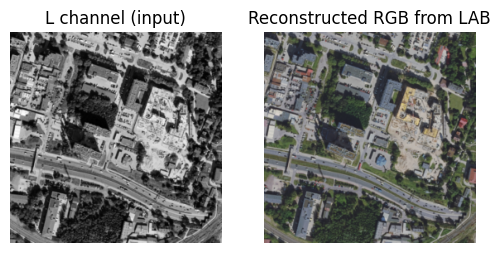

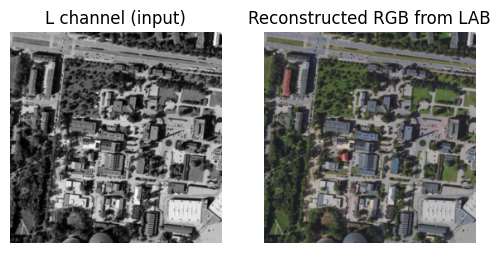

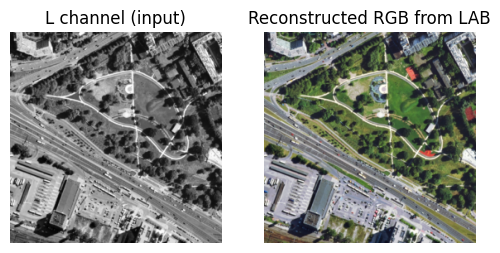

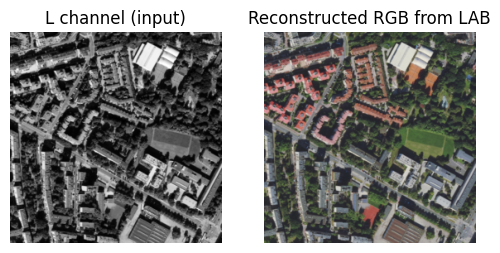

In [ ]:
import matplotlib.pyplot as plt

def visualize_augmented_samples(dataset, n=4, off = 0):
    for i in range(off, off + n):
        L, ab = dataset[i]
        L_vis = L[0].numpy()
        L_scaled = L * 100.0
        ab_scaled = ab * 127.0
        lab = torch.cat([L_scaled, ab_scaled], dim=0).unsqueeze(0)  # (1, 3, H, W)
        rgb = K.color.lab_to_rgb(lab).squeeze().permute(1, 2, 0).clamp(0, 1).cpu().numpy()

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(L_vis, cmap='gray')
        plt.title('L channel (input)')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(rgb)
        plt.title('Reconstructed RGB from LAB')
        plt.axis('off')

        plt.show()

augmented_dataset = AerialColorizationDataset(TRAIN_DIR)
visualize_augmented_samples(augmented_dataset, n=4, off=950)

In [ ]:
from torchinfo import summary

USE_CBAM = True
model = UNetCBAM(use_cbam=USE_CBAM).to("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(4, 1, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
UNetCBAM                                 [4, 2, 512, 512]          --
├─ConvBlock: 1-1                         [4, 64, 512, 512]         --
│    └─Sequential: 2-1                   [4, 64, 512, 512]         --
│    │    └─Conv2d: 3-1                  [4, 64, 512, 512]         640
│    │    └─ReLU: 3-2                    [4, 64, 512, 512]         --
│    │    └─Conv2d: 3-3                  [4, 64, 512, 512]         36,928
│    │    └─ReLU: 3-4                    [4, 64, 512, 512]         --
├─CBAM: 1-2                              [4, 64, 512, 512]         --
│    └─ChannelAttention: 2-2             [4, 64, 512, 512]         --
│    │    └─AdaptiveAvgPool2d: 3-5       [4, 64, 1, 1]             --
│    │    └─Sequential: 3-6              [4, 64, 1, 1]             1,024
│    │    └─AdaptiveMaxPool2d: 3-7       [4, 64, 1, 1]             --
│    │    └─Sequential: 3-8              [4, 64, 1, 1]             (recursive

In [ ]:
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetCBAM().to(device)
dummy_input = torch.randn(1, 1, 512, 512).to(device)

writer = SummaryWriter(LOG_DIR)

# This must succeed:
with torch.no_grad():
    output = model(dummy_input)

writer.add_graph(model, dummy_input)
writer.flush()

In [ ]:
%load_ext tensorboard
print(LOG_DIR)

/content/drive/My Drive/logs1


In [ ]:
%tensorboard --logdir "/content/drive/My Drive/logs1"